### 차원축소 : 데이터 분포 가시화
fashion mnist 데이터가 어떤 분포로 흩어져있는지 가시화해보자.  
이를 위해 각 이미지들이 서로 유사한 것들은 가까운 위치에 놓이도록 차원축소해야 한다.
+ 인코더
    + `input_shape = (28, 28, 1)`
    + layer1 : `Conv2D(filters=16, kernel_size=3)` => (, 26, 26, 16)
    + layer2 : `Conv2D(filters=16, kernel_size=3)` => (, 24, 24, 16)
    + layer3 : `Flatten()`                         => (, 24x24x16)
    + layer4 : `Dense(128)`                        => (, 128)
+ 디코더
    + `input_shape = (128,)`
    + layer1 : `Dense(24x24x16)`                   => (, 24x24x16)
    + layer2 : `Reshape(target_shape=(24,24,16))`  => (, 24, 24, 16)
    + layer3 : `Conv2DTranspose(filters=16, kernel_size=3)`  => (, 26, 26, 16)
    + layer4 : `Conv2DTranspose(filters=1, kernel_size=3)`   => (, 28, 28, 1)

In [9]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

print(x_train.shape, x_test.shape)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)
print(x_train.shape, x_test.shape)

(60000, 28, 28) (10000, 28, 28)
(60000, 28, 28, 1) (10000, 28, 28, 1)


In [2]:
encoder = keras.models.Sequential([keras.layers.Conv2D(filters=16, kernel_size=3, activation='elu', input_shape=(28,28,1)),
                                   keras.layers.Conv2D(filters=16, kernel_size=3, activation='elu'),
                                   keras.layers.Flatten(),
                                   keras.layers.Dense(128, activation='elu')])

encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 16)        2320      
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
Total params: 1,182,256
Trainable params: 1,182,256
Non-trainable params: 0
_________________________________________________________________


In [6]:
decoder = keras.models.Sequential([keras.layers.Dense(9216, input_shape=(128,) , activation='elu'),
                                   keras.layers.Reshape(target_shape=(24,24,16)),
                                   keras.layers.Conv2DTranspose(filters=16, kernel_size=3, activation='elu'),
                                   keras.layers.Conv2DTranspose(filters=1, kernel_size=3, activation='elu')])

decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 9216)              1188864   
_________________________________________________________________
reshape (Reshape)            (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 26, 26, 16)        2320      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 1)         145       
Total params: 1,191,329
Trainable params: 1,191,329
Non-trainable params: 0
_________________________________________________________________


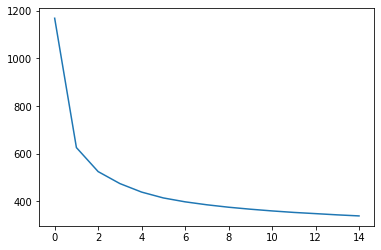

In [11]:
ae = keras.models.Sequential([encoder, decoder])

ae.compile(loss='mse')

history = ae.fit(x_train, x_train, epochs=15, verbose=0)

plt.plot(history.history['loss']);

위의 오토인코더의 인코더부분에서 잠재표현을 128차원의 데이터로 설정했다.  
이것을 시각화하기 위해 2차원으로 차원축소를 해보려고 하는데, t-SNE 기법을 사용해보자.  
x_train의 데이터 6만개 중 1만개에 대한 잠재표현을 인코더에서 얻고, 1만개의 잠재표현을 t-SNE 알고리즘을 이용해 2차원 임베딩 공간에 옮기면 된다.

c:\Users\yeonok\anaconda3\envs\deeplearning\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\yeonok\anaconda3\envs\deeplearning\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


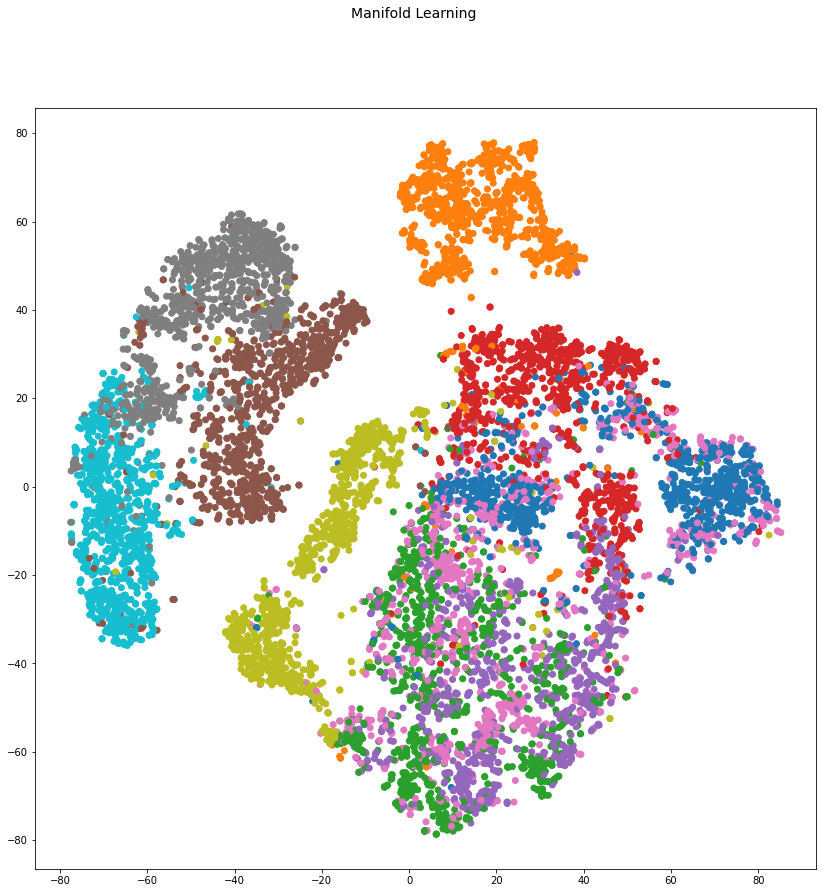

In [13]:
from sklearn import manifold

tsne = manifold.TSNE(n_components=2)

latent_rep = encoder.predict(x_train[:10000])
embedding = tsne.fit_transform(latent_rep)

fig = plt.figure(figsize=(14,14))
fig.suptitle('Manifold Learning', fontsize=14)
plt.scatter(embedding[:,0], embedding[:,1], c=y_train[:10000], cmap='tab10');   #y_train의 레이블에 따라 점의 색깔 결정됨

클래스별로 군집을 이루고 있는 것을 확인할 수 있다.  
그 중에서도 비슷한 클래스의 군집끼리도 모여있다. ex) 부츠-샌들-운동화  
상의 종류인 코드-풀오버-셔츠-T셔츠-드레스 군집들은 아주 혼란스럽게 섞여있으며,  
가방과 바지 두 클래스는 비슷한 클래스가 없어 독립적인 군집을 이루고 있다.